<a href="https://colab.research.google.com/github/Sharvari226/diabetic_retinopathy/blob/main/Diabetic_Retinopathy.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Install required libraries (PyTorch comes pre-installed in Colab, but add extras)
!pip install torch torchvision torchaudio
!pip install pandas scikit-learn opencv-python albumentations

# Import libraries
import os
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
from PIL import Image
import cv2
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score
import matplotlib.pyplot as plt
import albumentations as A
from albumentations.pytorch import ToTensorV2

Mounted at /content/drive


In [4]:
# List everything in your MyDrive
!ls "/content/drive/MyDrive/"

# If you see a folder like "DR_Project" or "DR Project" or "dr_project", list inside it
# Replace with what you actually see
!ls "/content/drive/MyDrive/DR_Project"                  # try this first
# !ls "/content/drive/MyDrive/DR Project"                # if there's a space
# !ls "/content/drive/MyDrive/dr_project"                # lowercase?

# Then go deeper
!ls "/content/drive/MyDrive/DR_Project/aptos"             # check if aptos folder exists
!ls "/content/drive/MyDrive/DR_Project/DRIMDB"            # check DRIMDB
!ls "/content/drive/MyDrive/DR_Project/dr_train"          # check your 1751 images

'13_Sharvari_Jadhav (1).pdf'
 13_Sharvari_Jadhav.pdf
 assignment6.gsheet
 Autocad
 Classroom
'Colab Notebooks'
 csi_sharvari.gsheet
 D1_I-Agro.zip
 dbms_4.gdoc
'Diabetic Retinopathy'
 Diabetic_Retinopathy_Shar.gdoc
 DR_Project
'DS Theory Chap.zip'
 IMG_20231102_120119.jpg
 IMG-20240214-WA0009.jpg
 lab01.gdoc
'LCA Ass 6 -write up (1).gdoc'
'LCA Ass 6 -write up.gdoc'
 LOGIC_LUMINARIES.gslides
 ML_CCA3.gdoc
 peace.gdoc
 Peace_poster.jpeg
 projdbms.gdoc
'Research Paper 1.gdoc'
'Science fair.gslides'
'Sharvari Jadhav.gdoc'
'SHARVARI JADHAV_Resume.pdf'
'sharvari_resume (1).pdf'
'sharvari_resume (2).pdf'
 sharvari_resume.pdf
 Sorting.gdoc
'Sparse Matrix.gdoc'
 StudentMarksheet-1.png
 Survey_Result.gsheet
'Tickets - Odoo Hackathon 2025 (08_11_2025 08_00_00) - Sharvari Jadhav.pdf'
'Tickets - Odoo Hackathon 2025 (11_08_2025 08_00_00) - Anmolkaur Aidan .pdf'
 UIUX_Assignment_2.gsheet
'UIUX_CCA 3 : WEALTHVISION.gdoc'
'Untitled document (1).gdoc'
'Untitled document (2).gdoc'
'Untitled document (3).

In [9]:
import os

DATA_PATH = '/content/drive/MyDrive/DR_Project/data/'

# List all items in the data folder
if os.path.exists(DATA_PATH):
    contents = os.listdir(DATA_PATH)
    print("Contents of /data/ folder:")
    for item in contents:
        print("  -", item)

        # If it's a directory, show a few files inside
        item_full = os.path.join(DATA_PATH, item)
        if os.path.isdir(item_full):
            try:
                sub_files = os.listdir(item_full)[:10]  # first 10 files/folders
                print(f"    Inside {item}/:", sub_files)
                if len(os.listdir(item_full)) > 10:
                    print("    ... and more")
            except:
                print("    (could not read inside)")
else:
    print("The /data/ folder does not exist! Check if Drive is mounted and path is correct.")

Contents of /data/ folder:
  - aptos
    Inside aptos/: ['train.csv', 'train_images']
  - dr_train
    Inside dr_train/: ['0', '1', '2', '3', '4']
  - DRIMDB
    Inside DRIMDB/: ['Outlier', 'Bad', 'Good']


In [12]:
# ========================================
# 1. Mount Drive & Install Dependencies
# ========================================
from google.colab import drive
drive.mount('/content/drive')

!pip install torch torchvision torchaudio --quiet
!pip install pandas scikit-learn opencv-python albumentations --quiet

import os
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
from PIL import Image
import cv2
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import albumentations as A
from albumentations.pytorch import ToTensorV2

# ========================================
# 2. Correct Paths (Your Exact Structure)
# ========================================
BASE_PATH = '/content/drive/MyDrive/DR_Project/data/'

APTOS_CSV = os.path.join(BASE_PATH, 'aptos/train.csv')
APTOS_IMG_ROOT = os.path.join(BASE_PATH, 'dr_train/')           # contains folders 0,1,2,3,4
DRIMDB_GOOD_DIR = os.path.join(BASE_PATH, 'DRIMDB/Good/')
DRIMDB_BAD_DIR = os.path.join(BASE_PATH, 'DRIMDB/Bad/')

# Quick verification
print("CSV exists:", os.path.exists(APTOS_CSV))
print("dr_train subfolders:", os.listdir(APTOS_IMG_ROOT))
print("Good images:", len(os.listdir(DRIMDB_GOOD_DIR)))
print("Bad images:", len(os.listdir(DRIMDB_BAD_DIR)))

# ========================================
# 3. Load APTOS Data (from class subfolders 0-4)
# ========================================
image_paths = []
labels = []

for class_label in range(5):  # 0 to 4
    class_folder = os.path.join(APTOS_IMG_ROOT, str(class_label))
    if os.path.exists(class_folder):
        for img_name in os.listdir(class_folder):
            if img_name.lower().endswith(('.png', '.jpg', '.jpeg')):
                image_paths.append(os.path.join(class_folder, img_name))
                labels.append(class_label)

print(f"Found {len(image_paths)} APTOS images")

aptos_df = pd.DataFrame({'image_path': image_paths, 'diagnosis': labels})
print("Class distribution:\n", aptos_df['diagnosis'].value_counts().sort_index())

# Train/val split
train_df, val_df = train_test_split(
    aptos_df, test_size=0.2, stratify=aptos_df['diagnosis'], random_state=42
)
print(f"Train: {len(train_df)}, Val: {len(val_df)}")

# ========================================
# 4. Load DRIMDB (Quality Assessment)
# ========================================
drimdb_images = []
drimdb_labels = []

# Good quality → label 1
for img_name in os.listdir(DRIMDB_GOOD_DIR):
    if img_name.lower().endswith(('.jpg', '.png', '.jpeg')):
        drimdb_images.append(os.path.join(DRIMDB_GOOD_DIR, img_name))
        drimdb_labels.append(1)

# Bad quality → label 0
for img_name in os.listdir(DRIMDB_BAD_DIR):
    if img_name.lower().endswith(('.jpg', '.png', '.jpeg')):
        drimdb_images.append(os.path.join(DRIMDB_BAD_DIR, img_name))
        drimdb_labels.append(0)

print(f"DRIMDB total: {len(drimdb_images)} (Good: {drimdb_labels.count(1)}, Bad: {drimdb_labels.count(0)})")

drimdb_train_img, drimdb_val_img, drimdb_train_lbl, drimdb_val_lbl = train_test_split(
    drimdb_images, drimdb_labels, test_size=0.2, stratify=drimdb_labels, random_state=42
)

# ========================================
# 5. Transforms
# ========================================
train_transform = A.Compose([
    A.Resize(224, 224),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.RandomRotate90(p=0.5),
    A.RandomBrightnessContrast(p=0.3),
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    ToTensorV2()
])

val_transform = A.Compose([
    A.Resize(224, 224),
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    ToTensorV2()
])

# ========================================
# 6. Custom Datasets
# ========================================
class QualityDataset(Dataset):
    def __init__(self, images, labels, transform=None):
        self.images = images
        self.labels = labels
        self.transform = transform

    def __len__(self): return len(self.images)

    def __getitem__(self, idx):
        img_path = self.images[idx]
        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        label = self.labels[idx]

        if self.transform:
            augmented = self.transform(image=image)
            image = augmented['image']

        return image, label

class DRDataset(Dataset):
    def __init__(self, df, transform=None):
        self.df = df.reset_index(drop=True)
        self.transform = transform

    def __len__(self): return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        image = cv2.imread(row['image_path'])
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        label = row['diagnosis']

        if self.transform:
            augmented = self.transform(image=image)
            image = augmented['image']

        return image, label

# ========================================
# 7. DataLoaders
# ========================================
BATCH_SIZE = 32

quality_train_ds = QualityDataset(drimdb_train_img, drimdb_train_lbl, train_transform)
quality_val_ds = QualityDataset(drimdb_val_img, drimdb_val_lbl, val_transform)
quality_train_loader = DataLoader(quality_train_ds, batch_size=BATCH_SIZE, shuffle=True)
quality_val_loader = DataLoader(quality_val_ds, batch_size=BATCH_SIZE, shuffle=False)

dr_train_ds = DRDataset(train_df, train_transform)
dr_val_ds = DRDataset(val_df, val_transform)
dr_train_loader = DataLoader(dr_train_ds, batch_size=BATCH_SIZE, shuffle=True)
dr_val_loader = DataLoader(dr_val_ds, batch_size=BATCH_SIZE, shuffle=False)

# ========================================
# 8. CBAM Attention Module
# ========================================
class ChannelAttention(nn.Module):
    def __init__(self, in_planes, ratio=16):
        super().__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.max_pool = nn.AdaptiveMaxPool2d(1)
        self.fc = nn.Sequential(
            nn.Conv2d(in_planes, in_planes // ratio, 1, bias=False),
            nn.ReLU(),
            nn.Conv2d(in_planes // ratio, in_planes, 1, bias=False)
        )
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        avg_out = self.fc(self.avg_pool(x))
        max_out = self.fc(self.max_pool(x))
        return self.sigmoid(avg_out + max_out)

class SpatialAttention(nn.Module):
    def __init__(self, kernel_size=7):
        super().__init__()
        self.conv = nn.Conv2d(2, 1, kernel_size, padding=kernel_size//2, bias=False)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        avg_out = torch.mean(x, dim=1, keepdim=True)
        max_out, _ = torch.max(x, dim=1, keepdim=True)
        x = torch.cat([avg_out, max_out], dim=1)
        return self.sigmoid(self.conv(x))

class CBAM(nn.Module):
    def __init__(self, planes):
        super().__init__()
        self.ca = ChannelAttention(planes)
        self.sa = SpatialAttention()

    def forward(self, x):
        return x * self.ca(x) * self.sa(x)

# ========================================
# 9. Models
# ========================================
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Quality Model (Binary: Good vs Bad)
quality_model = models.resnet18(pretrained=True)
quality_model.fc = nn.Linear(quality_model.fc.in_features, 1)  # sigmoid output
quality_model = quality_model.to(device)

# DR Model with CBAM
class ResNetCBAM(nn.Module):
    def __init__(self, num_classes=5):
        super().__init__()
        self.base = models.resnet50(pretrained=True)
        # Add CBAM after layer3 and layer4
        self.base.layer3[-1].add_module("cbam", CBAM(1024))
        self.base.layer4[-1].add_module("cbam", CBAM(2048))
        self.base.fc = nn.Linear(self.base.fc.in_features, num_classes)

    def forward(self, x):
        return self.base(x)

dr_model = ResNetCBAM(num_classes=5).to(device)

# ========================================
# 10. Training Function
# ========================================
def train_model(model, train_loader, val_loader, criterion, optimizer, epochs=10, binary=False):
    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            if binary:
                labels = labels.float().unsqueeze(1)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        # Validation
        model.eval()
        val_preds, val_trues = [], []
        val_loss = 0.0
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                if binary:
                    labels = labels.float().unsqueeze(1)
                outputs = model(images)
                val_loss += criterion(outputs, labels).item()

                if binary:
                    preds = (torch.sigmoid(outputs) > 0.5).cpu().numpy()
                else:
                    preds = torch.argmax(outputs, dim=1).cpu().numpy()
                val_preds.extend(preds)
                val_trues.extend(labels.cpu().numpy() if not binary else labels.cpu().numpy())

        print(f"Epoch {epoch+1}/{epochs} | Train Loss: {running_loss/len(train_loader):.4f} | Val Loss: {val_loss/len(val_loader):.4f}")
        print(classification_report(val_trues, val_preds))
    return model

# ========================================
# 11. Train Quality Model First
# ========================================
quality_criterion = nn.BCEWithLogitsLoss()
quality_optimizer = optim.Adam(quality_model.parameters(), lr=1e-4)

print("Training Image Quality Assessment Model...")
quality_model = train_model(
    quality_model, quality_train_loader, quality_val_loader,
    quality_criterion, quality_optimizer, epochs=8, binary=True
)

# ========================================
# 12. Train DR Detection Model
# ========================================
dr_criterion = nn.CrossEntropyLoss()
dr_optimizer = optim.Adam(dr_model.parameters(), lr=1e-4)

print("\nTraining Diabetic Retinopathy Detection Model with Attention...")
dr_model = train_model(
    dr_model, dr_train_loader, dr_val_loader,
    dr_criterion, dr_optimizer, epochs=15, binary=False
)

# ========================================
# 13. Inference Pipeline (Quality → DR)
# ========================================
severity_map = {0: 'No DR', 1: 'Mild', 2: 'Moderate', 3: 'Severe', 4: 'Proliferative DR'}

def predict_image(img_path, quality_model, dr_model, threshold=0.5):
    image = cv2.imread(img_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    transformed = val_transform(image=image)['image'].unsqueeze(0).to(device)

    quality_model.eval()
    dr_model.eval()

    with torch.no_grad():
        q_logits = quality_model(transformed)
        quality_prob = torch.sigmoid(q_logits).item()

        if quality_prob < threshold:
            return f"Bad Quality Image (Prob: {quality_prob:.2f}) → Skip DR prediction"

        dr_out = dr_model(transformed)
        dr_pred = torch.argmax(dr_out, dim=1).item()
        dr_prob = torch.softmax(dr_out, dim=1).max().item()

    return f"Good Quality | Prediction: {severity_map[dr_pred]} (Confidence: {dr_prob:.2f})"

# Test on a random image
sample_path = train_df['image_path'].iloc[0]  # change index as needed
print("\nSample Prediction:")
print(predict_image(sample_path, quality_model, dr_model))

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
CSV exists: True
dr_train subfolders: ['0', '1', '2', '3', '4']
Good images: 126
Bad images: 70
Found 1751 APTOS images
Class distribution:
 diagnosis
0    1203
1     113
2     300
3      49
4      86
Name: count, dtype: int64
Train: 1400, Val: 351
DRIMDB total: 194 (Good: 125, Bad: 69)


/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weig

Training Image Quality Assessment Model...
Epoch 1/8 | Train Loss: 0.4114 | Val Loss: 0.1221
              precision    recall  f1-score   support

         0.0       1.00      0.93      0.96        14
         1.0       0.96      1.00      0.98        25

    accuracy                           0.97        39
   macro avg       0.98      0.96      0.97        39
weighted avg       0.98      0.97      0.97        39

Epoch 2/8 | Train Loss: 0.0700 | Val Loss: 0.0394
              precision    recall  f1-score   support

         0.0       1.00      0.93      0.96        14
         1.0       0.96      1.00      0.98        25

    accuracy                           0.97        39
   macro avg       0.98      0.96      0.97        39
weighted avg       0.98      0.97      0.97        39

Epoch 3/8 | Train Loss: 0.0159 | Val Loss: 0.0323
              precision    recall  f1-score   support

         0.0       1.00      0.93      0.96        14
         1.0       0.96      1.00      0.98 

In [13]:
# Save both trained models to your Drive
MODEL_SAVE_PATH = '/content/drive/MyDrive/DR_Project/models/'
os.makedirs(MODEL_SAVE_PATH, exist_ok=True)

torch.save(quality_model.state_dict(), os.path.join(MODEL_SAVE_PATH, 'quality_model_resnet18.pth'))
torch.save(dr_model.state_dict(), os.path.join(MODEL_SAVE_PATH, 'dr_model_resnet50_cbam.pth'))

print("Both models saved successfully to DR_Project/models/")

Both models saved successfully to DR_Project/models/


In [14]:
# Compute class weights (inverse frequency)
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

classes = np.array([0,1,2,3,4])
weights = compute_class_weight('balanced', classes=classes, y=train_df['diagnosis'])
class_weights = torch.tensor(weights, dtype=torch.float).to(device)

print("Class weights:", class_weights)

# Use weighted loss
dr_criterion = nn.CrossEntropyLoss(weight=class_weights)

Class weights: tensor([0.2911, 3.1111, 1.1667, 7.1795, 4.0580], device='cuda:0')


DR Detection - Detailed Report
              precision    recall  f1-score   support

       No DR       0.96      1.00      0.98       241
        Mild       0.55      0.52      0.53        23
    Moderate       0.69      0.82      0.75        60
      Severe       0.50      0.10      0.17        10
         PDR       0.75      0.18      0.29        17

    accuracy                           0.87       351
   macro avg       0.69      0.52      0.54       351
weighted avg       0.86      0.87      0.85       351

Quadratic Weighted Kappa: 0.8218


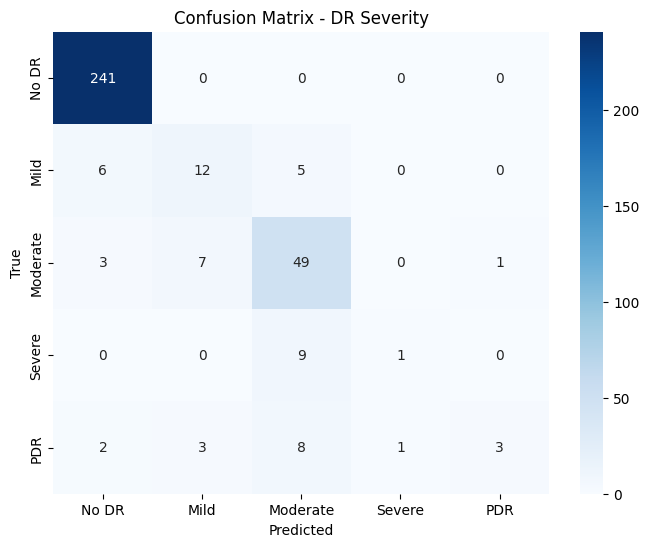

Specificity (No DR correctly identified): 1.0000
Sensitivity (Referable DR: Moderate+): 0.9000


In [16]:
from sklearn.metrics import classification_report, confusion_matrix, cohen_kappa_score
import seaborn as sns

# Full evaluation on validation set for DR model
dr_model.eval()
all_preds = []
all_labels = []
all_probs = []

with torch.no_grad():
    for images, labels in dr_val_loader:
        images = images.to(device)
        outputs = dr_model(images)
        probs = torch.softmax(outputs, dim=1).cpu().numpy()
        preds = torch.argmax(outputs, dim=1).cpu().numpy()
        all_preds.extend(preds)
        all_labels.extend(labels.numpy())
        all_probs.extend(probs)

# Classification report
print("DR Detection - Detailed Report")
print(classification_report(all_labels, all_preds, target_names=['No DR', 'Mild', 'Moderate', 'Severe', 'PDR']))

# Quadratic Weighted Kappa (standard metric for DR grading)
kappa = cohen_kappa_score(all_labels, all_preds, weights='quadratic')
print(f"Quadratic Weighted Kappa: {kappa:.4f}")

# Confusion Matrix
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['No DR', 'Mild', 'Moderate', 'Severe', 'PDR'],
            yticklabels=['No DR', 'Mild', 'Moderate', 'Severe', 'PDR'])
plt.ylabel('True')
plt.xlabel('Predicted')
plt.title('Confusion Matrix - DR Severity')
plt.show()

# Specificity (for No DR class) and Sensitivity (for referable DR: classes 2+)
tn = cm[0,0]
fp = cm[0,1:].sum()
fn = cm[1:,0].sum()
tp = cm[1:,1:].sum()

specificity = tn / (tn + fp)
sensitivity_referable = tp / (tp + fn)  # Detecting moderate or worse

print(f"Specificity (No DR correctly identified): {specificity:.4f}")
print(f"Sensitivity (Referable DR: Moderate+): {sensitivity_referable:.4f}")

In [17]:
import random

# Test 10 random images from validation set
val_paths = val_df['image_path'].tolist()
random_paths = random.sample(val_paths, 10)

print("Testing full pipeline on 10 random images:\n")
for path in random_paths:
    print(predict_image(path, quality_model, dr_model))
    print("-" * 50)

Testing full pipeline on 10 random images:

Good Quality | Prediction: No DR (Confidence: 1.00)
--------------------------------------------------
Good Quality | Prediction: No DR (Confidence: 1.00)
--------------------------------------------------
Good Quality | Prediction: Moderate (Confidence: 1.00)
--------------------------------------------------
Good Quality | Prediction: No DR (Confidence: 1.00)
--------------------------------------------------
Good Quality | Prediction: No DR (Confidence: 1.00)
--------------------------------------------------
Good Quality | Prediction: No DR (Confidence: 0.95)
--------------------------------------------------
Good Quality | Prediction: No DR (Confidence: 1.00)
--------------------------------------------------
Good Quality | Prediction: No DR (Confidence: 1.00)
--------------------------------------------------
Good Quality | Prediction: No DR (Confidence: 1.00)
--------------------------------------------------
Good Quality | Prediction:

In [18]:
# Save models to Drive
torch.save(quality_model.state_dict(), '/content/drive/MyDrive/DR_Project/quality_model_resnet18.pth')
torch.save(dr_model.state_dict(), '/content/drive/MyDrive/DR_Project/dr_model_resnet50_cbam.pth')

print("Models saved successfully!")

Models saved successfully!


Processing: 0083ee8054ee.png


/usr/local/lib/python3.12/dist-packages/torch/nn/modules/module.py:1866: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)


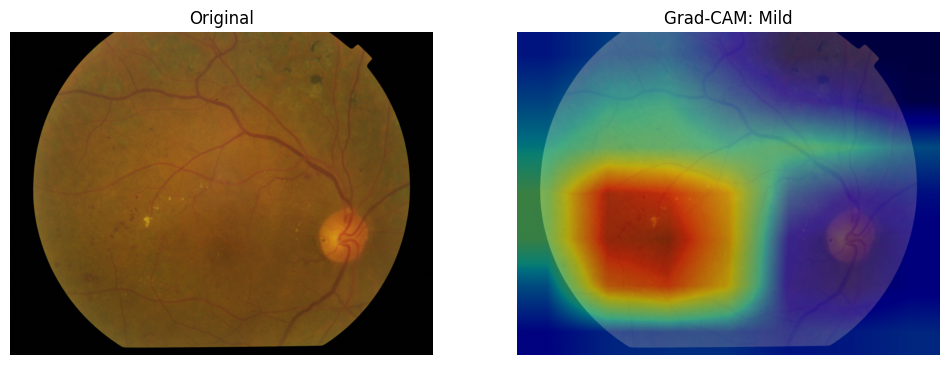

Processing: 299086c6d1b5.png


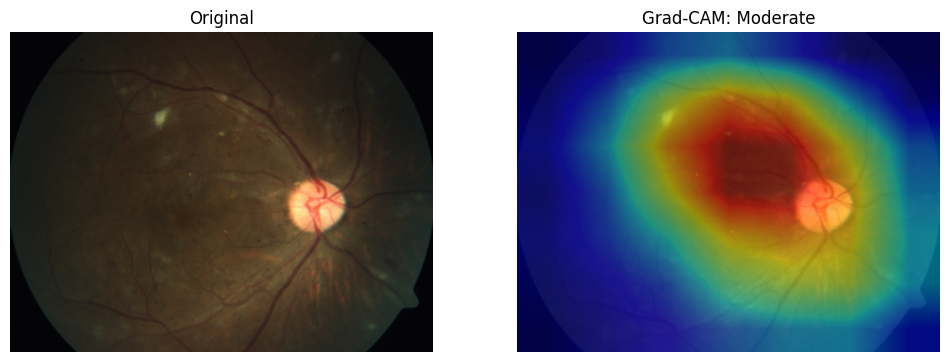

Processing: 0d9a9896f801.png


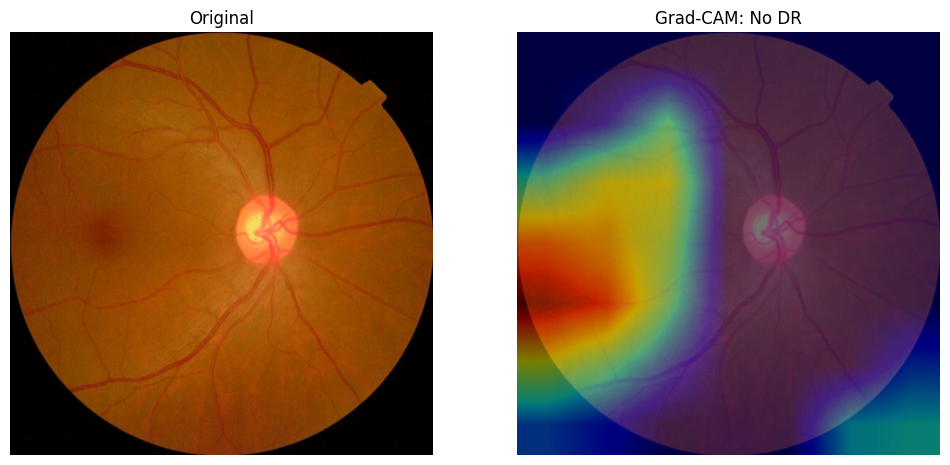

Processing: 8dafa62f9322.png


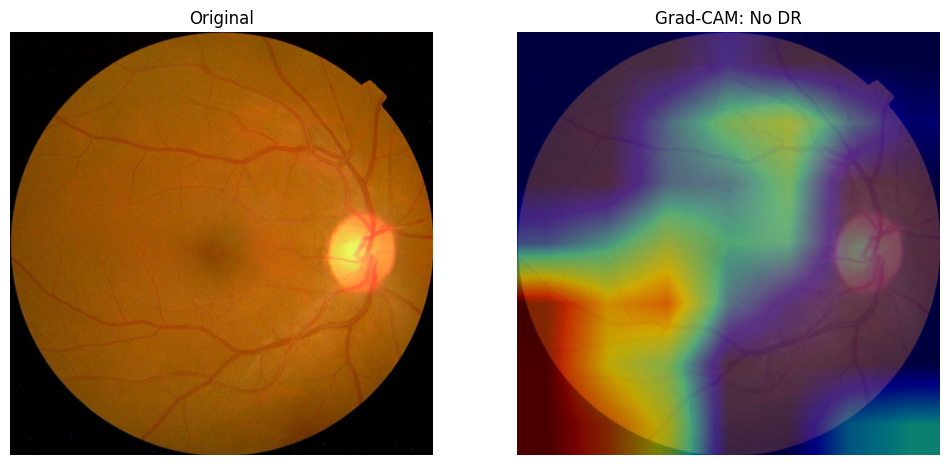

Processing: eebd1e195952.png


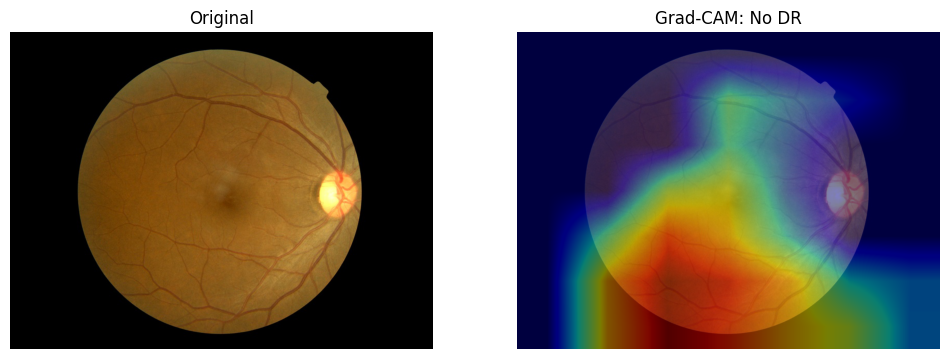

In [24]:
import torch.nn.functional as F
import numpy as np
import cv2
import matplotlib.pyplot as plt

def grad_cam(model, img_path, target_layer=None):
    model.eval()

    # Default to the last convolutional layer in layer4 of the ResNet base
    if target_layer is None:
        # Target the conv3 layer of the last bottleneck block in layer4.
        # This is a standard conv layer suitable for Grad-CAM.
        target_layer = model.base.layer4[-1].conv3

    # Store activations and gradients
    # Using lists to capture, then taking the first element, ensures clarity
    # and handles potential multiple calls if hooks weren't explicitly removed.
    activations = []
    gradients = []

    def save_activation(module, input, output):
        activations.append(output.detach()) # Store the output feature map

    def save_gradient(module, grad_input, grad_output):
        gradients.append(grad_output[0].detach()) # Store the gradients w.r.t. the output of the target_layer

    # Register hooks
    handle_act = target_layer.register_forward_hook(save_activation)
    handle_grad = target_layer.register_backward_hook(save_gradient)

    # Load and preprocess image
    img_rgb = cv2.imread(img_path)
    img_rgb = cv2.cvtColor(img_rgb, cv2.COLOR_BGR2RGB)
    input_tensor = val_transform(image=img_rgb)['image'].unsqueeze(0).to(device)
    input_tensor.requires_grad_(True) # Ensure gradients are computed for this tensor

    # Forward pass
    output = model(input_tensor)
    pred_class = output.argmax(dim=1).item()
    pred_score = output[:, pred_class]

    # Backward pass (compute gradients for the predicted class score)
    model.zero_grad() # Clear previous gradients across the entire model
    pred_score.backward(retain_graph=True) # Backpropagate the score of the predicted class

    # Remove hooks
    handle_act.remove()
    handle_grad.remove()

    # Check if activations and gradients were captured
    if not activations or not gradients:
        print("Failed to capture activations or gradients from the target layer.")
        return

    # Get the stored activations and gradients (remove batch dimension)
    # These should now be (C, H, W) tensors
    feats = activations[0].squeeze(0)
    grads = gradients[0].squeeze(0)

    # Pool gradients (Global Average Pooling) to get neuron importance weights
    # weights shape: (C, 1, 1) after mean over H and W, keepdim=True
    weights = torch.mean(grads, dim=(1, 2), keepdim=True)

    # Create CAM: element-wise product of activations and weights, then sum across channels
    # cam shape: (H, W) after sum over C
    cam = (feats * weights).sum(dim=0)
    cam = F.relu(cam) # Apply ReLU to only keep positive contributions

    cam = cam.cpu().numpy()

    # Resize CAM to original image dimensions
    cam = cv2.resize(cam, (img_rgb.shape[1], img_rgb.shape[0]), interpolation=cv2.INTER_LINEAR)
    cam = np.maximum(cam, 0) # Ensure all values are non-negative
    if np.max(cam) > 0:
        cam = cam / np.max(cam) # Normalize to [0, 1] for visualization
    else:
        cam = np.zeros_like(cam) # Handle case where all values are zero (no relevant activation)

    # Visualize
    plt.figure(figsize=(12,6))
    plt.subplot(1,2,1)
    plt.imshow(img_rgb)
    plt.title("Original")
    plt.axis('off')

    plt.subplot(1,2,2)
    plt.imshow(img_rgb)
    plt.imshow(cam, cmap='jet', alpha=0.5)
    plt.title(f"Grad-CAM: {severity_map[pred_class]}")
    plt.axis('off')
    plt.show()

# Test
sample_paths = val_df['image_path'].sample(5).tolist()
for path in sample_paths:
    print(f"Processing: {os.path.basename(path)}")
    grad_cam(dr_model, path)